# Generative Basic Assignment (2024/03/13)
#### Questions(1,2) are below
#### Contact -> toa2413@naver.com / 송인혁(투빅스20기)

In [2]:
import datetime
import os

import torch
import torchvision
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import matplotlib.pylab as plt

import torchvision.datasets as datasets
import torchvision.transforms as transforms

import numpy as np

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [3]:
transform = transforms.Compose([transforms.ToTensor()])

train_dataset = datasets.MNIST(
    root="../data", train=True, transform=transform, download=True)

test_dataset = datasets.MNIST(
    root="../data", train=False, transform=transform, download=True)

train_loader = DataLoader(
    train_dataset, batch_size=100, shuffle=True, num_workers=4, pin_memory=False)

test_loader = DataLoader(
    test_dataset, batch_size=100, shuffle=False, num_workers=4)

100.0%


Extracting ../data/MNIST/raw/train-images-idx3-ubyte.gz to ../data/MNIST/raw



100.0%


Extracting ../data/MNIST/raw/train-labels-idx1-ubyte.gz to ../data/MNIST/raw



100.0%


Extracting ../data/MNIST/raw/t10k-images-idx3-ubyte.gz to ../data/MNIST/raw



100.0%

Extracting ../data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ../data/MNIST/raw



### Q1. Encoder/Decoder Implementation
    Show me your visualizations(MNIST images) using a VAE model made up of your own 'Encoder2/Decoder2'
    I can see your visualizations at the last part of this code file (Assignment 1 ; Visualization)
    
***You can refer to the examples right under this markdown, please make your own Encoder (Class name; Encoder2/Decoder2)***

In [4]:
# You can freely choose one of architectures you want that looks promising
class Encoder(nn.Module):    
    def __init__(self, input_dim, hidden_dim, hidden_dim2, latent_dim):
        super(Encoder, self).__init__()
        self.input1 = nn.Linear(input_dim, hidden_dim)
        self.input2 = nn.Linear(hidden_dim, hidden_dim2)
        self.mean = nn.Linear(hidden_dim2, latent_dim)
        self.var = nn.Linear (hidden_dim2, latent_dim)
        
        self.LeakyReLU = nn.LeakyReLU(0.2)        
        self.training = True
        
    def forward(self, x):
        h_ = self.LeakyReLU(self.input1(x))
        h_ = self.LeakyReLU(self.input2(h_))
        mean = self.mean(h_)
        log_var = self.var(h_)                         
        return mean, log_var

In [5]:
class Encoder2(nn.Module):
    def __init__(self,x_dim,h_dim,z_dim):
        super().__init__()

        self.fc1 = nn.Sequential(
            nn.Linear(x_dim,h_dim),
            nn.LeakyReLU(),
            nn.Dropout(0.2)
        )

        self.fc2 = nn.Sequential(
            nn.Linear(h_dim,h_dim),
            nn.LeakyReLU(),
            nn.Dropout(0.2)
        )

        self.mu = nn.Linear(h_dim,z_dim)
        self.var = nn.Linear(h_dim,z_dim)

    def forward(self,x):
        x = self.fc1(x)
        x = self.fc2(x)

        mu = self.mu(x)
        logvar = self.var(x)

        return mu, logvar

In [6]:
class Decoder(nn.Module):
    def __init__(self, latent_dim, hidden_dim, hidden_dim2, output_dim):
        super(Decoder, self).__init__()
        self.hidden1 = nn.Linear(latent_dim, hidden_dim2)
        self.hidden2 = nn.Linear(hidden_dim2, hidden_dim)
        self.output = nn.Linear(hidden_dim, output_dim)        
        self.LeakyReLU = nn.LeakyReLU(0.2)
        
    def forward(self, x):
        h = self.LeakyReLU(self.hidden1(x))
        h = self.LeakyReLU(self.hidden2(h))        
        x_hat = torch.sigmoid(self.output(h))
        return x_hat

In [7]:
class Decoder2(nn.Module):
    def __init__(self,x_dim,h_dim,z_dim):
        super().__init__()

        self.fc1 = nn.Sequential(
            nn.Linear(z_dim,h_dim),
            nn.LeakyReLU(),
            nn.Dropout(0.2)
        )

        self.fc2 = nn.Sequential(
            nn.Linear(h_dim,h_dim),
            nn.LeakyReLU(),
            nn.Dropout(0.2)
        )

        self.p = nn.Sequential(
                nn.Linear(h_dim,x_dim),
                nn.Sigmoid()
            )


    def forward(self,z):
        z = self.fc1(z)
        z = self.fc2(z)

        p = self.p(z)

        return p

In [8]:
class Model(nn.Module):
    def __init__(self, Encoder, Decoder):
        super(Model, self).__init__()
        self.Encoder = Encoder.to(device)
        self.Decoder = Decoder.to(device)

    # Think about why you need reparameterization trick (Hint; backpropagation)
    def reparameterization(self, mean, var):
        epsilon = torch.randn_like(var).to(device)                
        z = mean + var*epsilon                          
        return z
                        
    def forward(self, x):
        mean, log_var = self.Encoder(x)
        z = self.reparameterization(mean, torch.exp(0.5 * log_var)) 
        x_hat = self.Decoder(z)        
        return x_hat, mean, log_var

In [29]:
# Any modifications are allowed depending on your own Encoder2/Decoder2
# -----------------------------------
beta = 1
x_dim  = 784
hidden_dim = 512
latent_dim = 256
epochs = 50
batch_size = 100
# -----------------------------------



# encoder = Encoder(input_dim=x_dim, hidden_dim=hidden_dim, hidden_dim2=hidden_dim2, latent_dim=latent_dim)
encoder = Encoder2(x_dim,hidden_dim,latent_dim)

# decoder = Decoder(latent_dim=latent_dim, hidden_dim = hidden_dim, hidden_dim2=hidden_dim2, output_dim = x_dim)
decoder = Decoder2(x_dim,hidden_dim,latent_dim)

model = Model(Encoder=encoder, Decoder=decoder).to(device)

### Q2. (Optional Assignment)
    Refering to Beta-VAE(https://openreview.net/forum?id=Sy2fzU9gl), give any kind of manipulations on pre-made loss function, and visualize your samples.
    It would be nice to see whether the fidelity of sample data is improved or not! Also guess why.
***Warning)  you don't have to take all the contents of this paper! Look carefully at the Equation (4)***

In [31]:
# (Optional Assignment)
def loss_function(x, x_hat, mean, log_var,beta):
    reproduction_loss = nn.functional.binary_cross_entropy(x_hat, x, reduction='sum')
    # Think about how to calculate KLDivergence in closed form (Hint; assumptions for Gaussian), please refer to the following links
    # https://stats.stackexchange.com/questions/7440/kl-divergence-between-two-univariate-gaussians
    KLD = - 0.5 * torch.sum(1+ log_var - mean.pow(2) - log_var.exp())
    KLD = beta * KLD
    return reproduction_loss, KLD

optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

In [34]:
def train(epoch, model, train_loader, optimizer):
    model.train()
    train_loss = 0
    for batch_idx, (x, _) in enumerate(train_loader):
        x = x.view(batch_size, x_dim)
        x = x.to(device)

        optimizer.zero_grad()
        x_hat, mean, log_var = model(x)
        BCE, KLD = loss_function(x, x_hat, mean, log_var,beta)
        loss = BCE + KLD
        
        train_loss += loss.item()  
        loss.backward()
        optimizer.step()
          
        if batch_idx % 100 == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\t Loss: {:.6f}'.format(
                epoch, batch_idx * len(x), len(train_loader.dataset),
                100. * batch_idx / len(train_loader),
                loss.item() / len(x)))
            
    print("======> Epoch: {} Average loss: {:.4f}".format(
        epoch, train_loss / len(train_loader.dataset)))

In [35]:
def test(epoch, model, test_loader):
    model.eval()
    test_loss = 0
    with torch.no_grad():
        for batch_idx, (x, _) in enumerate(test_loader):
            x = x.view(batch_size, x_dim)
            x = x.to(device)        
            x_hat, mean, log_var = model(x)
            BCE, KLD = loss_function(x, x_hat, mean, log_var,beta)
            loss = BCE + KLD

            test_loss += loss.item()

            if batch_idx == 0:
                n = min(x.size(0), 8)
                comparison = torch.cat([x[:n], x_hat.view(batch_size, x_dim)[:n]])
                grid = torchvision.utils.make_grid(comparison.cpu())

In [36]:
# Trackning the process
# If you have difficulty on installing 'tqdm', modifications are allowed. Not necessary 
from tqdm.auto import tqdm

# Training an VAE model, and record losses
for epoch in tqdm(range(0, epochs)):
    train(epoch, model, train_loader, optimizer)
    test(epoch, model, test_loader)
    print("\n")


  0%|          | 0/50 [00:00<?, ?it/s]

Train Epoch: 0 [0/60000 (0%)]	 Loss: 545.627930
Train Epoch: 0 [10000/60000 (17%)]	 Loss: 204.287344
Train Epoch: 0 [20000/60000 (33%)]	 Loss: 194.465254
Train Epoch: 0 [30000/60000 (50%)]	 Loss: 175.980703
Train Epoch: 0 [40000/60000 (67%)]	 Loss: 174.247773
Train Epoch: 0 [50000/60000 (83%)]	 Loss: 174.925176
======> Epoch: 0 Average loss: 187.0761


  2%|▏         | 1/50 [00:03<02:51,  3.49s/it]



Train Epoch: 1 [0/60000 (0%)]	 Loss: 161.811816
Train Epoch: 1 [10000/60000 (17%)]	 Loss: 151.275537
Train Epoch: 1 [20000/60000 (33%)]	 Loss: 161.133965
Train Epoch: 1 [30000/60000 (50%)]	 Loss: 156.476543
Train Epoch: 1 [40000/60000 (67%)]	 Loss: 155.051572
Train Epoch: 1 [50000/60000 (83%)]	 Loss: 147.381670
======> Epoch: 1 Average loss: 155.7265


  4%|▍         | 2/50 [00:06<02:29,  3.12s/it]



Train Epoch: 2 [0/60000 (0%)]	 Loss: 142.910732
Train Epoch: 2 [10000/60000 (17%)]	 Loss: 143.399922
Train Epoch: 2 [20000/60000 (33%)]	 Loss: 145.392627
Train Epoch: 2 [30000/60000 (50%)]	 Loss: 139.767227
Train Epoch: 2 [40000/60000 (67%)]	 Loss: 132.928271
Train Epoch: 2 [50000/60000 (83%)]	 Loss: 137.384033
======> Epoch: 2 Average loss: 141.0838


  6%|▌         | 3/50 [00:09<02:21,  3.01s/it]



Train Epoch: 3 [0/60000 (0%)]	 Loss: 136.290586
Train Epoch: 3 [10000/60000 (17%)]	 Loss: 137.852383
Train Epoch: 3 [20000/60000 (33%)]	 Loss: 134.424062
Train Epoch: 3 [30000/60000 (50%)]	 Loss: 136.667441
Train Epoch: 3 [40000/60000 (67%)]	 Loss: 137.328496
Train Epoch: 3 [50000/60000 (83%)]	 Loss: 127.545547
======> Epoch: 3 Average loss: 131.8055


  8%|▊         | 4/50 [00:11<02:03,  2.69s/it]



Train Epoch: 4 [0/60000 (0%)]	 Loss: 129.247041
Train Epoch: 4 [10000/60000 (17%)]	 Loss: 130.829336
Train Epoch: 4 [20000/60000 (33%)]	 Loss: 131.022402
Train Epoch: 4 [30000/60000 (50%)]	 Loss: 125.453213
Train Epoch: 4 [40000/60000 (67%)]	 Loss: 130.854160
Train Epoch: 4 [50000/60000 (83%)]	 Loss: 128.643926
======> Epoch: 4 Average loss: 127.4595


 10%|█         | 5/50 [00:15<02:15,  3.01s/it]



Train Epoch: 5 [0/60000 (0%)]	 Loss: 126.366396
Train Epoch: 5 [10000/60000 (17%)]	 Loss: 123.134072
Train Epoch: 5 [20000/60000 (33%)]	 Loss: 124.230820
Train Epoch: 5 [30000/60000 (50%)]	 Loss: 127.185576
Train Epoch: 5 [40000/60000 (67%)]	 Loss: 127.374795
Train Epoch: 5 [50000/60000 (83%)]	 Loss: 133.035830
======> Epoch: 5 Average loss: 125.2316


 12%|█▏        | 6/50 [00:18<02:16,  3.09s/it]



Train Epoch: 6 [0/60000 (0%)]	 Loss: 126.630098
Train Epoch: 6 [10000/60000 (17%)]	 Loss: 120.285752
Train Epoch: 6 [20000/60000 (33%)]	 Loss: 129.188848
Train Epoch: 6 [30000/60000 (50%)]	 Loss: 125.494658
Train Epoch: 6 [40000/60000 (67%)]	 Loss: 118.551045
Train Epoch: 6 [50000/60000 (83%)]	 Loss: 123.437598
======> Epoch: 6 Average loss: 123.9142


 14%|█▍        | 7/50 [00:21<02:16,  3.16s/it]



Train Epoch: 7 [0/60000 (0%)]	 Loss: 117.402197
Train Epoch: 7 [10000/60000 (17%)]	 Loss: 124.484658
Train Epoch: 7 [20000/60000 (33%)]	 Loss: 119.342764
Train Epoch: 7 [30000/60000 (50%)]	 Loss: 126.782773
Train Epoch: 7 [40000/60000 (67%)]	 Loss: 121.828486
Train Epoch: 7 [50000/60000 (83%)]	 Loss: 124.443789
======> Epoch: 7 Average loss: 122.7274


 16%|█▌        | 8/50 [00:24<02:06,  3.01s/it]



Train Epoch: 8 [0/60000 (0%)]	 Loss: 124.259756
Train Epoch: 8 [10000/60000 (17%)]	 Loss: 124.530752
Train Epoch: 8 [20000/60000 (33%)]	 Loss: 119.174141
Train Epoch: 8 [30000/60000 (50%)]	 Loss: 119.882949
Train Epoch: 8 [40000/60000 (67%)]	 Loss: 126.726279
Train Epoch: 8 [50000/60000 (83%)]	 Loss: 122.016387
======> Epoch: 8 Average loss: 121.5447


 18%|█▊        | 9/50 [00:27<02:07,  3.10s/it]



Train Epoch: 9 [0/60000 (0%)]	 Loss: 125.496348
Train Epoch: 9 [10000/60000 (17%)]	 Loss: 117.692900
Train Epoch: 9 [20000/60000 (33%)]	 Loss: 113.906904
Train Epoch: 9 [30000/60000 (50%)]	 Loss: 117.183467
Train Epoch: 9 [40000/60000 (67%)]	 Loss: 118.283916
Train Epoch: 9 [50000/60000 (83%)]	 Loss: 120.783574
======> Epoch: 9 Average loss: 120.8476


 20%|██        | 10/50 [00:31<02:14,  3.36s/it]



Train Epoch: 10 [0/60000 (0%)]	 Loss: 116.317031
Train Epoch: 10 [10000/60000 (17%)]	 Loss: 125.524355
Train Epoch: 10 [20000/60000 (33%)]	 Loss: 124.294902
Train Epoch: 10 [30000/60000 (50%)]	 Loss: 122.280332
Train Epoch: 10 [40000/60000 (67%)]	 Loss: 127.583516
Train Epoch: 10 [50000/60000 (83%)]	 Loss: 117.893711
======> Epoch: 10 Average loss: 120.3034


 22%|██▏       | 11/50 [00:34<02:05,  3.22s/it]



Train Epoch: 11 [0/60000 (0%)]	 Loss: 126.090156
Train Epoch: 11 [10000/60000 (17%)]	 Loss: 121.919170
Train Epoch: 11 [20000/60000 (33%)]	 Loss: 120.561006
Train Epoch: 11 [30000/60000 (50%)]	 Loss: 117.194336
Train Epoch: 11 [40000/60000 (67%)]	 Loss: 122.932148
Train Epoch: 11 [50000/60000 (83%)]	 Loss: 120.961895
======> Epoch: 11 Average loss: 119.8918


 24%|██▍       | 12/50 [00:38<02:10,  3.43s/it]



Train Epoch: 12 [0/60000 (0%)]	 Loss: 121.749619
Train Epoch: 12 [10000/60000 (17%)]	 Loss: 123.321504
Train Epoch: 12 [20000/60000 (33%)]	 Loss: 117.207090
Train Epoch: 12 [30000/60000 (50%)]	 Loss: 121.528926
Train Epoch: 12 [40000/60000 (67%)]	 Loss: 120.792539
Train Epoch: 12 [50000/60000 (83%)]	 Loss: 115.510342
======> Epoch: 12 Average loss: 119.5222


 26%|██▌       | 13/50 [00:40<01:56,  3.14s/it]



Train Epoch: 13 [0/60000 (0%)]	 Loss: 121.166074
Train Epoch: 13 [10000/60000 (17%)]	 Loss: 123.115010
Train Epoch: 13 [20000/60000 (33%)]	 Loss: 119.928008
Train Epoch: 13 [30000/60000 (50%)]	 Loss: 119.425859
Train Epoch: 13 [40000/60000 (67%)]	 Loss: 117.009326
Train Epoch: 13 [50000/60000 (83%)]	 Loss: 121.152070
======> Epoch: 13 Average loss: 119.1505


 28%|██▊       | 14/50 [00:44<01:54,  3.19s/it]



Train Epoch: 14 [0/60000 (0%)]	 Loss: 117.687676
Train Epoch: 14 [10000/60000 (17%)]	 Loss: 118.841992
Train Epoch: 14 [20000/60000 (33%)]	 Loss: 119.322695
Train Epoch: 14 [30000/60000 (50%)]	 Loss: 118.200381
Train Epoch: 14 [40000/60000 (67%)]	 Loss: 117.485791
Train Epoch: 14 [50000/60000 (83%)]	 Loss: 126.536943
======> Epoch: 14 Average loss: 118.9049


 30%|███       | 15/50 [00:46<01:44,  2.99s/it]



Train Epoch: 15 [0/60000 (0%)]	 Loss: 121.496826
Train Epoch: 15 [10000/60000 (17%)]	 Loss: 125.732510
Train Epoch: 15 [20000/60000 (33%)]	 Loss: 120.675605
Train Epoch: 15 [30000/60000 (50%)]	 Loss: 122.444414
Train Epoch: 15 [40000/60000 (67%)]	 Loss: 115.333145
Train Epoch: 15 [50000/60000 (83%)]	 Loss: 118.670928
======> Epoch: 15 Average loss: 118.5458


 32%|███▏      | 16/50 [00:50<01:51,  3.27s/it]



Train Epoch: 16 [0/60000 (0%)]	 Loss: 117.346543
Train Epoch: 16 [10000/60000 (17%)]	 Loss: 119.142441
Train Epoch: 16 [20000/60000 (33%)]	 Loss: 123.427188
Train Epoch: 16 [30000/60000 (50%)]	 Loss: 122.683711
Train Epoch: 16 [40000/60000 (67%)]	 Loss: 119.692227
Train Epoch: 16 [50000/60000 (83%)]	 Loss: 124.883096
======> Epoch: 16 Average loss: 118.3617


 34%|███▍      | 17/50 [00:54<01:51,  3.38s/it]



Train Epoch: 17 [0/60000 (0%)]	 Loss: 113.355059
Train Epoch: 17 [10000/60000 (17%)]	 Loss: 119.031445
Train Epoch: 17 [20000/60000 (33%)]	 Loss: 120.101836
Train Epoch: 17 [30000/60000 (50%)]	 Loss: 119.111865
Train Epoch: 17 [40000/60000 (67%)]	 Loss: 120.105889
Train Epoch: 17 [50000/60000 (83%)]	 Loss: 117.743193
======> Epoch: 17 Average loss: 118.1614


 36%|███▌      | 18/50 [00:56<01:41,  3.16s/it]



Train Epoch: 18 [0/60000 (0%)]	 Loss: 115.769043
Train Epoch: 18 [10000/60000 (17%)]	 Loss: 120.521719
Train Epoch: 18 [20000/60000 (33%)]	 Loss: 115.573682
Train Epoch: 18 [30000/60000 (50%)]	 Loss: 119.020205
Train Epoch: 18 [40000/60000 (67%)]	 Loss: 115.044336
Train Epoch: 18 [50000/60000 (83%)]	 Loss: 117.588105
======> Epoch: 18 Average loss: 118.0263


 38%|███▊      | 19/50 [01:00<01:41,  3.29s/it]



Train Epoch: 19 [0/60000 (0%)]	 Loss: 124.136562
Train Epoch: 19 [10000/60000 (17%)]	 Loss: 122.855957
Train Epoch: 19 [20000/60000 (33%)]	 Loss: 116.722090
Train Epoch: 19 [30000/60000 (50%)]	 Loss: 118.297520
Train Epoch: 19 [40000/60000 (67%)]	 Loss: 111.892676
Train Epoch: 19 [50000/60000 (83%)]	 Loss: 122.900254
======> Epoch: 19 Average loss: 117.8109


 40%|████      | 20/50 [01:02<01:30,  3.03s/it]



Train Epoch: 20 [0/60000 (0%)]	 Loss: 117.723477
Train Epoch: 20 [10000/60000 (17%)]	 Loss: 120.786377
Train Epoch: 20 [20000/60000 (33%)]	 Loss: 109.237324
Train Epoch: 20 [30000/60000 (50%)]	 Loss: 122.090156
Train Epoch: 20 [40000/60000 (67%)]	 Loss: 124.098086
Train Epoch: 20 [50000/60000 (83%)]	 Loss: 114.224102
======> Epoch: 20 Average loss: 117.6899


 42%|████▏     | 21/50 [01:05<01:25,  2.94s/it]



Train Epoch: 21 [0/60000 (0%)]	 Loss: 117.662383
Train Epoch: 21 [10000/60000 (17%)]	 Loss: 115.984482
Train Epoch: 21 [20000/60000 (33%)]	 Loss: 120.363291
Train Epoch: 21 [30000/60000 (50%)]	 Loss: 120.517314
Train Epoch: 21 [40000/60000 (67%)]	 Loss: 119.494150
Train Epoch: 21 [50000/60000 (83%)]	 Loss: 117.798203
======> Epoch: 21 Average loss: 117.6071


 44%|████▍     | 22/50 [01:08<01:22,  2.95s/it]



Train Epoch: 22 [0/60000 (0%)]	 Loss: 115.585010
Train Epoch: 22 [10000/60000 (17%)]	 Loss: 111.858369
Train Epoch: 22 [20000/60000 (33%)]	 Loss: 121.101611
Train Epoch: 22 [30000/60000 (50%)]	 Loss: 117.201680
Train Epoch: 22 [40000/60000 (67%)]	 Loss: 119.570869
Train Epoch: 22 [50000/60000 (83%)]	 Loss: 118.161445
======> Epoch: 22 Average loss: 117.3961


 46%|████▌     | 23/50 [01:11<01:18,  2.90s/it]



Train Epoch: 23 [0/60000 (0%)]	 Loss: 123.609346
Train Epoch: 23 [10000/60000 (17%)]	 Loss: 127.649639
Train Epoch: 23 [20000/60000 (33%)]	 Loss: 122.931748
Train Epoch: 23 [30000/60000 (50%)]	 Loss: 113.329512
Train Epoch: 23 [40000/60000 (67%)]	 Loss: 123.272646
Train Epoch: 23 [50000/60000 (83%)]	 Loss: 113.213379
======> Epoch: 23 Average loss: 117.1451


 48%|████▊     | 24/50 [01:14<01:19,  3.06s/it]



Train Epoch: 24 [0/60000 (0%)]	 Loss: 115.976475
Train Epoch: 24 [10000/60000 (17%)]	 Loss: 114.699316
Train Epoch: 24 [20000/60000 (33%)]	 Loss: 121.124834
Train Epoch: 24 [30000/60000 (50%)]	 Loss: 116.495645
Train Epoch: 24 [40000/60000 (67%)]	 Loss: 115.393086
Train Epoch: 24 [50000/60000 (83%)]	 Loss: 120.715801
======> Epoch: 24 Average loss: 117.0317


 50%|█████     | 25/50 [01:17<01:17,  3.10s/it]



Train Epoch: 25 [0/60000 (0%)]	 Loss: 119.120830
Train Epoch: 25 [10000/60000 (17%)]	 Loss: 115.790303
Train Epoch: 25 [20000/60000 (33%)]	 Loss: 118.314609
Train Epoch: 25 [30000/60000 (50%)]	 Loss: 114.520996
Train Epoch: 25 [40000/60000 (67%)]	 Loss: 116.730889
Train Epoch: 25 [50000/60000 (83%)]	 Loss: 111.088916
======> Epoch: 25 Average loss: 116.9132


 52%|█████▏    | 26/50 [01:20<01:08,  2.86s/it]



Train Epoch: 26 [0/60000 (0%)]	 Loss: 120.061328
Train Epoch: 26 [10000/60000 (17%)]	 Loss: 119.327246
Train Epoch: 26 [20000/60000 (33%)]	 Loss: 116.630381
Train Epoch: 26 [30000/60000 (50%)]	 Loss: 114.913066
Train Epoch: 26 [40000/60000 (67%)]	 Loss: 117.451865
Train Epoch: 26 [50000/60000 (83%)]	 Loss: 114.259414
======> Epoch: 26 Average loss: 116.7035


 54%|█████▍    | 27/50 [01:22<01:04,  2.81s/it]



Train Epoch: 27 [0/60000 (0%)]	 Loss: 116.715264
Train Epoch: 27 [10000/60000 (17%)]	 Loss: 116.535664
Train Epoch: 27 [20000/60000 (33%)]	 Loss: 118.101514
Train Epoch: 27 [30000/60000 (50%)]	 Loss: 116.685498
Train Epoch: 27 [40000/60000 (67%)]	 Loss: 117.874424
Train Epoch: 27 [50000/60000 (83%)]	 Loss: 113.262100
======> Epoch: 27 Average loss: 116.6135


 56%|█████▌    | 28/50 [01:25<01:03,  2.87s/it]



Train Epoch: 28 [0/60000 (0%)]	 Loss: 118.262539
Train Epoch: 28 [10000/60000 (17%)]	 Loss: 113.160273
Train Epoch: 28 [20000/60000 (33%)]	 Loss: 118.785820
Train Epoch: 28 [30000/60000 (50%)]	 Loss: 119.743086
Train Epoch: 28 [40000/60000 (67%)]	 Loss: 113.011533
Train Epoch: 28 [50000/60000 (83%)]	 Loss: 119.206934
======> Epoch: 28 Average loss: 116.5333


 58%|█████▊    | 29/50 [01:28<00:57,  2.75s/it]



Train Epoch: 29 [0/60000 (0%)]	 Loss: 119.637266
Train Epoch: 29 [10000/60000 (17%)]	 Loss: 118.767412
Train Epoch: 29 [20000/60000 (33%)]	 Loss: 116.113398
Train Epoch: 29 [30000/60000 (50%)]	 Loss: 116.660977
Train Epoch: 29 [40000/60000 (67%)]	 Loss: 121.951348
Train Epoch: 29 [50000/60000 (83%)]	 Loss: 112.048389
======> Epoch: 29 Average loss: 116.3309


 60%|██████    | 30/50 [01:31<00:55,  2.78s/it]



Train Epoch: 30 [0/60000 (0%)]	 Loss: 114.961328
Train Epoch: 30 [10000/60000 (17%)]	 Loss: 115.955654
Train Epoch: 30 [20000/60000 (33%)]	 Loss: 117.605039
Train Epoch: 30 [30000/60000 (50%)]	 Loss: 118.548242
Train Epoch: 30 [40000/60000 (67%)]	 Loss: 119.270488
Train Epoch: 30 [50000/60000 (83%)]	 Loss: 112.626484
======> Epoch: 30 Average loss: 116.2487


 62%|██████▏   | 31/50 [01:34<00:54,  2.85s/it]



Train Epoch: 31 [0/60000 (0%)]	 Loss: 113.118955
Train Epoch: 31 [10000/60000 (17%)]	 Loss: 117.430049
Train Epoch: 31 [20000/60000 (33%)]	 Loss: 113.580137
Train Epoch: 31 [30000/60000 (50%)]	 Loss: 120.040547
Train Epoch: 31 [40000/60000 (67%)]	 Loss: 113.342832
Train Epoch: 31 [50000/60000 (83%)]	 Loss: 122.342109
======> Epoch: 31 Average loss: 116.2024


 64%|██████▍   | 32/50 [01:36<00:49,  2.74s/it]



Train Epoch: 32 [0/60000 (0%)]	 Loss: 111.132539
Train Epoch: 32 [10000/60000 (17%)]	 Loss: 118.713447
Train Epoch: 32 [20000/60000 (33%)]	 Loss: 119.209863
Train Epoch: 32 [30000/60000 (50%)]	 Loss: 117.252246
Train Epoch: 32 [40000/60000 (67%)]	 Loss: 114.949541
Train Epoch: 32 [50000/60000 (83%)]	 Loss: 121.162285
======> Epoch: 32 Average loss: 116.1425


 66%|██████▌   | 33/50 [01:39<00:45,  2.65s/it]



Train Epoch: 33 [0/60000 (0%)]	 Loss: 110.308584
Train Epoch: 33 [10000/60000 (17%)]	 Loss: 121.596094
Train Epoch: 33 [20000/60000 (33%)]	 Loss: 115.285576
Train Epoch: 33 [30000/60000 (50%)]	 Loss: 110.952354
Train Epoch: 33 [40000/60000 (67%)]	 Loss: 122.010801
Train Epoch: 33 [50000/60000 (83%)]	 Loss: 123.166426
======> Epoch: 33 Average loss: 116.0540


 68%|██████▊   | 34/50 [01:42<00:45,  2.82s/it]



Train Epoch: 34 [0/60000 (0%)]	 Loss: 116.938584
Train Epoch: 34 [10000/60000 (17%)]	 Loss: 110.361406
Train Epoch: 34 [20000/60000 (33%)]	 Loss: 120.133662
Train Epoch: 34 [30000/60000 (50%)]	 Loss: 127.312754
Train Epoch: 34 [40000/60000 (67%)]	 Loss: 119.979346
Train Epoch: 34 [50000/60000 (83%)]	 Loss: 117.949189
======> Epoch: 34 Average loss: 115.9317


 70%|███████   | 35/50 [01:44<00:40,  2.68s/it]



Train Epoch: 35 [0/60000 (0%)]	 Loss: 116.482344
Train Epoch: 35 [10000/60000 (17%)]	 Loss: 118.712871
Train Epoch: 35 [20000/60000 (33%)]	 Loss: 119.593359
Train Epoch: 35 [30000/60000 (50%)]	 Loss: 112.634639
Train Epoch: 35 [40000/60000 (67%)]	 Loss: 114.690977
Train Epoch: 35 [50000/60000 (83%)]	 Loss: 110.385664
======> Epoch: 35 Average loss: 115.9382


 72%|███████▏  | 36/50 [01:48<00:40,  2.89s/it]



Train Epoch: 36 [0/60000 (0%)]	 Loss: 109.696465
Train Epoch: 36 [10000/60000 (17%)]	 Loss: 107.447178
Train Epoch: 36 [20000/60000 (33%)]	 Loss: 115.097480
Train Epoch: 36 [30000/60000 (50%)]	 Loss: 112.751582
Train Epoch: 36 [40000/60000 (67%)]	 Loss: 116.400244
Train Epoch: 36 [50000/60000 (83%)]	 Loss: 117.858662
======> Epoch: 36 Average loss: 115.8291


 74%|███████▍  | 37/50 [01:51<00:41,  3.17s/it]



Train Epoch: 37 [0/60000 (0%)]	 Loss: 116.607490
Train Epoch: 37 [10000/60000 (17%)]	 Loss: 115.376230
Train Epoch: 37 [20000/60000 (33%)]	 Loss: 119.598213
Train Epoch: 37 [30000/60000 (50%)]	 Loss: 113.056582
Train Epoch: 37 [40000/60000 (67%)]	 Loss: 121.530020
Train Epoch: 37 [50000/60000 (83%)]	 Loss: 112.571328
======> Epoch: 37 Average loss: 115.8216


 76%|███████▌  | 38/50 [01:55<00:39,  3.30s/it]



Train Epoch: 38 [0/60000 (0%)]	 Loss: 112.250889
Train Epoch: 38 [10000/60000 (17%)]	 Loss: 120.635625
Train Epoch: 38 [20000/60000 (33%)]	 Loss: 115.740547
Train Epoch: 38 [30000/60000 (50%)]	 Loss: 122.049941
Train Epoch: 38 [40000/60000 (67%)]	 Loss: 115.549492
Train Epoch: 38 [50000/60000 (83%)]	 Loss: 112.078672
======> Epoch: 38 Average loss: 115.6913


 78%|███████▊  | 39/50 [01:58<00:36,  3.28s/it]



Train Epoch: 39 [0/60000 (0%)]	 Loss: 117.860859
Train Epoch: 39 [10000/60000 (17%)]	 Loss: 109.728184
Train Epoch: 39 [20000/60000 (33%)]	 Loss: 118.734902
Train Epoch: 39 [30000/60000 (50%)]	 Loss: 110.548408
Train Epoch: 39 [40000/60000 (67%)]	 Loss: 114.741738
Train Epoch: 39 [50000/60000 (83%)]	 Loss: 112.763271
======> Epoch: 39 Average loss: 115.6639


 80%|████████  | 40/50 [02:01<00:31,  3.10s/it]



Train Epoch: 40 [0/60000 (0%)]	 Loss: 116.374062
Train Epoch: 40 [10000/60000 (17%)]	 Loss: 118.703115
Train Epoch: 40 [20000/60000 (33%)]	 Loss: 115.867900
Train Epoch: 40 [30000/60000 (50%)]	 Loss: 112.896631
Train Epoch: 40 [40000/60000 (67%)]	 Loss: 113.520898
Train Epoch: 40 [50000/60000 (83%)]	 Loss: 118.162227
======> Epoch: 40 Average loss: 115.6024


 82%|████████▏ | 41/50 [02:04<00:27,  3.03s/it]



Train Epoch: 41 [0/60000 (0%)]	 Loss: 114.308887
Train Epoch: 41 [10000/60000 (17%)]	 Loss: 115.506846
Train Epoch: 41 [20000/60000 (33%)]	 Loss: 116.639824
Train Epoch: 41 [30000/60000 (50%)]	 Loss: 119.017852
Train Epoch: 41 [40000/60000 (67%)]	 Loss: 110.515303
Train Epoch: 41 [50000/60000 (83%)]	 Loss: 115.723721
======> Epoch: 41 Average loss: 115.5809


 84%|████████▍ | 42/50 [02:06<00:22,  2.85s/it]



Train Epoch: 42 [0/60000 (0%)]	 Loss: 119.524082
Train Epoch: 42 [10000/60000 (17%)]	 Loss: 113.355918
Train Epoch: 42 [20000/60000 (33%)]	 Loss: 118.317109
Train Epoch: 42 [30000/60000 (50%)]	 Loss: 112.442168
Train Epoch: 42 [40000/60000 (67%)]	 Loss: 105.391816
Train Epoch: 42 [50000/60000 (83%)]	 Loss: 115.846748
======> Epoch: 42 Average loss: 115.4352


 86%|████████▌ | 43/50 [02:10<00:20,  2.99s/it]



Train Epoch: 43 [0/60000 (0%)]	 Loss: 113.889482
Train Epoch: 43 [10000/60000 (17%)]	 Loss: 115.921729
Train Epoch: 43 [20000/60000 (33%)]	 Loss: 112.591934
Train Epoch: 43 [30000/60000 (50%)]	 Loss: 113.955879
Train Epoch: 43 [40000/60000 (67%)]	 Loss: 112.595400
Train Epoch: 43 [50000/60000 (83%)]	 Loss: 118.924229
======> Epoch: 43 Average loss: 115.4091


 88%|████████▊ | 44/50 [02:13<00:19,  3.26s/it]



Train Epoch: 44 [0/60000 (0%)]	 Loss: 107.464258
Train Epoch: 44 [10000/60000 (17%)]	 Loss: 120.702373
Train Epoch: 44 [20000/60000 (33%)]	 Loss: 113.457686
Train Epoch: 44 [30000/60000 (50%)]	 Loss: 119.110957
Train Epoch: 44 [40000/60000 (67%)]	 Loss: 110.417939
Train Epoch: 44 [50000/60000 (83%)]	 Loss: 123.363096
======> Epoch: 44 Average loss: 115.4404


 90%|█████████ | 45/50 [02:16<00:14,  2.99s/it]



Train Epoch: 45 [0/60000 (0%)]	 Loss: 111.739141
Train Epoch: 45 [10000/60000 (17%)]	 Loss: 116.644297
Train Epoch: 45 [20000/60000 (33%)]	 Loss: 119.238740
Train Epoch: 45 [30000/60000 (50%)]	 Loss: 110.587725
Train Epoch: 45 [40000/60000 (67%)]	 Loss: 114.705244
Train Epoch: 45 [50000/60000 (83%)]	 Loss: 111.570049
======> Epoch: 45 Average loss: 115.3058


 92%|█████████▏| 46/50 [02:19<00:12,  3.16s/it]



Train Epoch: 46 [0/60000 (0%)]	 Loss: 116.159219
Train Epoch: 46 [10000/60000 (17%)]	 Loss: 116.000391
Train Epoch: 46 [20000/60000 (33%)]	 Loss: 116.547314
Train Epoch: 46 [30000/60000 (50%)]	 Loss: 115.150469
Train Epoch: 46 [40000/60000 (67%)]	 Loss: 115.290781
Train Epoch: 46 [50000/60000 (83%)]	 Loss: 122.142471
======> Epoch: 46 Average loss: 115.2926


 94%|█████████▍| 47/50 [02:22<00:08,  2.99s/it]



Train Epoch: 47 [0/60000 (0%)]	 Loss: 117.137812
Train Epoch: 47 [10000/60000 (17%)]	 Loss: 112.843164
Train Epoch: 47 [20000/60000 (33%)]	 Loss: 112.093535
Train Epoch: 47 [30000/60000 (50%)]	 Loss: 117.163018
Train Epoch: 47 [40000/60000 (67%)]	 Loss: 117.190879
Train Epoch: 47 [50000/60000 (83%)]	 Loss: 111.859219
======> Epoch: 47 Average loss: 115.2626


 96%|█████████▌| 48/50 [02:26<00:06,  3.26s/it]



Train Epoch: 48 [0/60000 (0%)]	 Loss: 114.883184
Train Epoch: 48 [10000/60000 (17%)]	 Loss: 113.079941
Train Epoch: 48 [20000/60000 (33%)]	 Loss: 120.042754
Train Epoch: 48 [30000/60000 (50%)]	 Loss: 113.669648
Train Epoch: 48 [40000/60000 (67%)]	 Loss: 112.710537
Train Epoch: 48 [50000/60000 (83%)]	 Loss: 116.867871
======> Epoch: 48 Average loss: 115.1804


 98%|█████████▊| 49/50 [02:29<00:03,  3.12s/it]



Train Epoch: 49 [0/60000 (0%)]	 Loss: 114.696758
Train Epoch: 49 [10000/60000 (17%)]	 Loss: 118.009629
Train Epoch: 49 [20000/60000 (33%)]	 Loss: 113.475967
Train Epoch: 49 [30000/60000 (50%)]	 Loss: 118.129004
Train Epoch: 49 [40000/60000 (67%)]	 Loss: 116.693066
Train Epoch: 49 [50000/60000 (83%)]	 Loss: 119.764102
======> Epoch: 49 Average loss: 115.2226


100%|██████████| 50/50 [02:32<00:00,  3.04s/it]

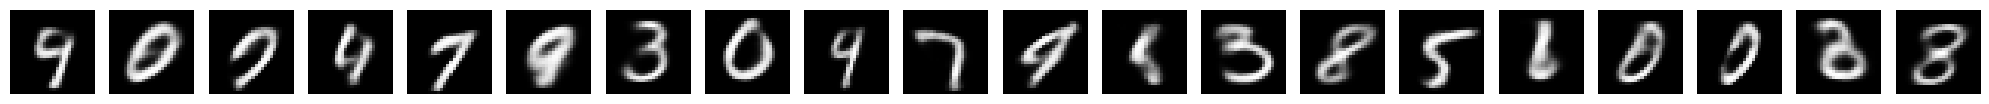

In [37]:
# After training decoder, begin visualize what comes after decoder given input z
def visualize(decoder,z):
    x_sample = decoder(z.to(device)).view(20,28,28).detach().cpu().numpy()
    fig, axes = plt.subplots(nrows=1, ncols=20, figsize=(20, 8))
    for i, ax in enumerate(axes.flat):
        ax.imshow(x_sample[i], cmap='gray')
        ax.axis('off')
    plt.tight_layout()
    plt.show()

z_sample = torch.randn(20,256)

# (Assignment 1 ; Visualization)
visualize(decoder,z_sample)

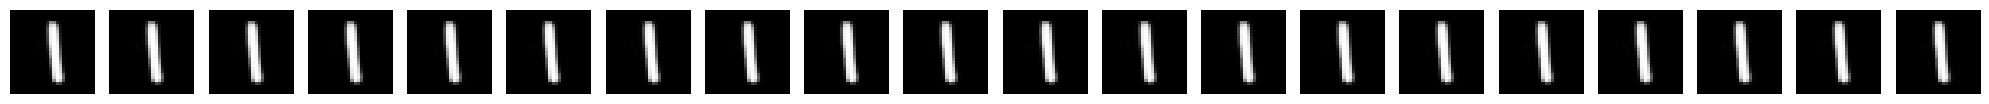

In [39]:
# Set seed numbers to take reproducibility
seed = 3
torch.manual_seed(seed)
# torch.cuda.manual_seed(seed)
np.random.seed(seed)

# Random z
z = torch.randn(256)
# Make copies
z = z.repeat(20,1)

# Interpolation in latent space z 
for i in range(20):
    z[i, 0] += i * 0.5 - (20 - 1) * 0.5 / 2

# (Assignment 1 ; Visualization)
visualize(decoder,z)

## Answer(Q2; Optional) : Please write any codes or statements below this space
